In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import binet as bt
%matplotlib inline

In [4]:
#Read data
df = pd.read_csv('fit_data_exports.csv')
df = df.replace(-np.inf, np.nan).dropna()

#Define quantile categories

def quantile_chances(df, RCA_bins = 20, T_bins = 40, xcp_bins = 40):
    df['log_RCA_cat_'+str(RCA_bins)] = ((RCA_bins/100.)*df['log_RCA'].rank(pct = True)).round(2)
    df["log_xcp_cat_"+str(xcp_bins)] = ((xcp_bins/100.)*df["log_xcp"].rank(pct = True)).round(2)
    df['T_cat_'+str(T_bins)] = ((T_bins/100.)*df.groupby('log_RCA_cat_'+str(RCA_bins))["T"].rank(pct = True)).round(2)

#     df = df[['ccode','pcode','log_RCA','log_xcp','T','RCA_bin_end','log_RCA_cat','log_xcp_cat','T_cat','ex_growth']]
    group_chances = df.groupby(['log_RCA_cat_'+str(RCA_bins),'T_cat_'+str(T_bins)]).mean().reset_index()[['log_RCA_cat_'+str(RCA_bins),'T_cat_'+str(T_bins),'RCA_bin_end']].rename(columns = {'RCA_bin_end': 'chances_'+str(RCA_bins)+'_'+str(T_bins)})
    
    return df.merge(group_chances)[['ccode','pcode','year','chances_'+str(RCA_bins)+'_'+str(T_bins)]]

In [5]:
#Try out many similar partitions. Use mean and std as result.

chances_1 = quantile_chances(df, RCA_bins = 65, T_bins = 65)
chances_2 = quantile_chances(df, RCA_bins = 65, T_bins = 75)
chances_3 = quantile_chances(df, RCA_bins = 65, T_bins = 85)
chances_4 = quantile_chances(df, RCA_bins = 75, T_bins = 65)
chances_5 = quantile_chances(df, RCA_bins = 75, T_bins = 75)
chances_6 = quantile_chances(df, RCA_bins = 75, T_bins = 85)
chances_7 = quantile_chances(df, RCA_bins = 85, T_bins = 65)
chances_8 = quantile_chances(df, RCA_bins = 85, T_bins = 75)
chances_9 = quantile_chances(df, RCA_bins = 85, T_bins = 85)

chances = chances_1.merge(chances_2).merge(chances_3).merge(chances_4).merge(chances_5)
chances = chances.merge(chances_6).merge(chances_7).merge(chances_8).merge(chances_9)

chances.sample(10)

# chances = chances.sample(1000)
# cols = [col for col in chances.columns if 'chances' in col]
# main(chances[cols].as_matrix().T)

cols = [col for col in chances.columns if 'chances' in col]
chances['chances_mean'] = chances[cols].mean(axis = 1)
chances['chances_std'] = chances[cols].std(axis = 1)

#Save table
chances[['ccode','pcode','year','chances_mean','chances_std']].to_csv('chances_pRCA.csv', index = False)

# for i, row in chances.sample(10000)[cols].iterrows():
#     plt.plot([10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210], row.values - row.values.mean(), alpha = 0.01, c='k')
    
# plt.ylim(-0.1, 0.1)
# plt.show()

# x = chances.sample(10000)
# plt.scatter(x['chances_mean'].values, x['chances_std'].values, c = 'k', alpha = 0.1)
# plt.show()

### Transition probabilities for pRCA. (~ Markov chain)

In [6]:
#chances at t_i
chn_i = df.merge(chances)[['ccode','pcode','year','chances_mean','chances_std']]
#chances at t_f = t_i + 1
chn_f = chn_i.copy()
chn_f['year'] = chn_f['year'] + 1
chn_f = chn_f[['ccode','pcode','year']].merge(chn_i)

chn_f = chn_f.rename(columns = {'chances_mean': 'chances_mean_f', 'chances_std': 'chances_std_f'})
chn_f['year'] = chn_f['year'] - 1

#merge, get the dynamic picture. Easy to relate to a markov chain reasoning.
chn_dyn = chn_i.merge(chn_f)

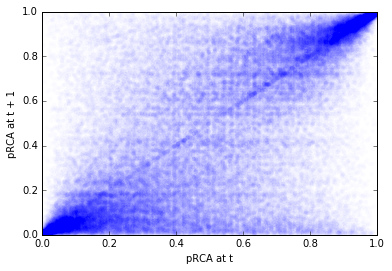

In [32]:
#Plot
x = chn_dyn#.sample(100000)
x['chances_mean_round'] = x['chances_mean'].round(2)
x = x.groupby('chances_mean_round').apply(lambda x: x.sample(1140))

plt.scatter(x.chances_mean, x.chances_mean_f, edgecolor = 'None', alpha = 0.01)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('pRCA at t')
plt.ylabel('pRCA at t + 1')
plt.show()
# .2 and .8 seem to be natural thresholds.

In [55]:
x['cat_i'] = np.floor((x.chances_mean + 0.4)/.6)
x['cat_f'] = np.floor((x.chances_mean_f + 0.4)/.6)

# print [3*[i] for i in x.groupby('cat_i').count().ccode.values] 
norm = np.array([23344, 23344, 23344,68478, 68478, 68478,23318, 23318, 23318])

100*np.true_divide(x.groupby(['cat_i','cat_f']).count().ccode.values,norm).round(2)

array([ 79.,  18.,   3.,  28.,  56.,  16.,   6.,  18.,  76.])

In [18]:
x = chn_dyn#.sample(100000)
x['chances_mean_round'] = x['chances_mean'].round(2)
x = x.groupby('chances_mean_round').count().sort_values(by = 'year')

,ccode,pcode,year,chances_mean,chances_std,chances_mean_f,chances_std_f
chances_mean_round,,,,,,,
0.52,1141,1141,1141,1141,1141,1141,1141
0.45,1185,1185,1185,1185,1185,1185,1185
0.59,1311,1311,1311,1311,1311,1311,1311
0.49,1315,1315,1315,1315,1315,1315,1315
0.46,1345,1345,1345,1345,1345,1345,1345
0.48,1350,1350,1350,1350,1350,1350,1350
0.39,1353,1353,1353,1353,1353,1353,1353
0.47,1406,1406,1406,1406,1406,1406,1406
0.53,1416,1416,1416,1416,1416,1416,1416


In [ ]:
dg = df.merge(chances)[['ccode','pcode','year','RCA_bin_end','chances_65_65',
 'chances_65_75',
 'chances_65_85',
 'chances_75_65',
 'chances_75_75',
 'chances_75_85',
 'chances_85_65',
 'chances_85_75',
 'chances_85_85']]
co = pd.read_csv('co.csv')
pr = pd.read_csv('pr.csv')

In [ ]:
for col in cols:
    dg['performance'+str(col[-6:])] = dg['RCA_bin_end'] - dg['chances'+str(col[-6:])]
    
cols_perf = [col for col in dg.columns if 'performance' in col]
dg['perf_mean'] = dg[cols_perf].mean(axis = 1)
dg['perf_std'] = dg[cols_perf].std(axis = 1)

# dg = dg.loc[abs(dg.chances_mean - 0.5) < .6]

# x = dg.groupby('ccode').count()['pcode']
# ccode_index = x.loc[x.values > 1000].index

# x = dg.groupby('pcode').count()['ccode']
# pcode_index = x.loc[x.values > 1000].index

In [ ]:
perf = dg[['ccode','pcode','year','perf_mean']]

# perf_std = perf.groupby('ccode').std().perf_mean.reset_index().rename(columns = {'perf_mean': 'perf_std'})

# perf.groupby('ccode').mean().reset_index().merge(perf_std).merge(co).sort_values(by = 'perf_mean')


# perf.sort_values(by = 'perf_mean')

### Dataset with actual outcome and expectations.

In [ ]:
dg = df.merge(chances[['ccode','pcode','year','chances_mean','chances_std']])[['ccode','pcode','year','RCA_bin_end','chances_mean','chances_std']]
co = pd.read_csv('co.csv')
pr = pd.read_csv('pr.csv')

In [ ]:
dg['performance'] = dg['RCA_bin_end'] - dg['chances_mean']
# dg = dg.loc[abs(dg.chances_mean - 0.5) < .6]

x = dg.groupby('ccode').count()['pcode']
ccode_index = x.loc[x.values > 1000].index

x = dg.groupby('pcode').count()['ccode']
pcode_index = x.loc[x.values > 1000].index

In [ ]:
# dg.loc[dg.ccode.isin(ccode_index)].groupby('ccode').mean().reset_index().merge(co).sort_values(by = 'performance')

dg.loc[dg.pcode.isin(pcode_index)].groupby('pcode').mean().reset_index().merge(pr).sort_values(by = 'performance')